In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Define the SP500 tickers and sector index ticker
sp500_tickers = ['AAPL']  # Example tickers
sector_index_ticker = 'XLC'  # Example sector index ticker for Technology

# Fetch historical data for these tickers and the sector index
def fetch_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return data

data = fetch_data(sp500_tickers, '2012-08-12', '2022-08-12')


[*********************100%%**********************]  1 of 1 completed


In [3]:

# Fetch the sector index data
sector_index_data = yf.download(sector_index_ticker, start='2004-08-12', end='2024-08-12')

def fetch_company_info(ticker):
    company = yf.Ticker(ticker)
    return company.info


[*********************100%%**********************]  1 of 1 completed


In [4]:
def calculate_metrics(info):
    metrics = {
        'P/E Ratio': info.get('forwardEps') / info.get('previousClose') if info.get('forwardEps') and info.get('previousClose') else None,
        # 'EPS': info.get('earningsPerShare'),
        'P/B Ratio': info.get('priceToBook'),
        'Dividend Yield': info.get('dividendYield'),
        'Dividend Payout Ratio': info.get('payoutRatio'),
        'ROE': info.get('returnOnEquity'),
        'ROA': info.get('returnOnAssets'),
        # 'ROI': info.get('returnOnInvestment'),
        'Beta': info.get('beta'),
        'Market Capitalization': info.get('marketCap'),
        'Revenue Growth': info.get('revenueGrowth'),
        # 'Net Profit Margin': info.get('netProfitMargin'),
        # 'Gross Profit Margin': info.get('grossProfitMargin'),
        # 'Operating Margin': info.get('operatingMargin'),
        'Debt-to-Equity Ratio': info.get('debtToEquity'),
        'Free Cash Flow': info.get('freeCashflow'),
        'Current Ratio': info.get('currentRatio'),
        'Quick Ratio': info.get('quickRatio'),
        # 'Interest Coverage Ratio': info.get('interestCoverageRatio'),
        # 'P/S Ratio': info.get('priceToSales'),
        'PEG Ratio': info.get('pegRatio'),
        # Additional metrics
        # 'Alpha': None,
        'Standard Deviation': None,
        'Value at Risk (VaR)': None,
        'Sharpe Ratio': None,
        'Sortino Ratio': None,
        'Maximum Drawdown': None,
        'Downside Deviation': None,
        'Tracking Error': None,
        'R-squared': None,
        'Treynor Ratio': None,
        'Information Ratio': None,
        'Conditional Value at Risk (CVaR)': None,
        'Beta-adjusted Sharpe Ratio': None,
        'Drawdown Duration': None,
        'Ulcer Index': None,
        'Jensen’s Alpha': None
    }
    return metrics


In [5]:

# Ensure company_data is defined
company_data = data.get('AAPL')
if company_data is None:
    raise ValueError("Data for 'AAPL' not found in fetched data.")

# Ensure sector_index_data is defined
if sector_index_data is None:
    raise ValueError(f"Data for sector index '{sector_index_ticker}' not found.")

company_info = fetch_company_info('AAPL')
metrics = calculate_metrics(company_info)


In [6]:

def calculate_standard_deviation(price_data):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.std()

def calculate_var(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.quantile(1 - confidence_level)

def calculate_sharpe_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std()

def calculate_sortino_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std()

def calculate_max_drawdown(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return drawdowns.min()

def calculate_downside_deviation(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    downside_returns = returns[returns < risk_free_rate / 252]
    return downside_returns.std()

def calculate_tracking_error(company_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Compute Tracking Error
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.std()

def calculate_r_squared(company_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Fit the linear regression model
    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    return model.score(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)

def calculate_treynor_ratio(price_data, risk_free_rate=0.01, beta=None):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / beta if beta else None

def calculate_information_ratio(price_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Compute Information Ratio
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.mean() / excess_returns.std()

def calculate_cvar(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

def calculate_beta(company_data, index_data):
    # Ensure both datasets have the same dates
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Calculate Beta
    covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

def calculate_beta_adjusted_sharpe_ratio(price_data, index_data, risk_free_rate=0.01):
    beta = calculate_beta(price_data, index_data)
    sharpe_ratio = calculate_sharpe_ratio(price_data, risk_free_rate)
    return sharpe_ratio / beta if beta else None

def calculate_drawdown_duration(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    drawdown_duration = (drawdowns < 0).astype(int).groupby((drawdowns >= 0).astype(int).cumsum()).cumsum().max()
    return drawdown_duration

def calculate_ulcer_index(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return (drawdowns ** 2).mean() ** 0.5

def calculate_jensens_alpha(price_data, index_data, risk_free_rate=0.01):
    # Ensure both datasets have the same dates
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()

    # Check if there are any overlapping dates
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")

    # Ensure both series are aligned
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]

    # Calculate Jensen’s Alpha
    beta = calculate_beta(price_data, index_data)
    expected_return = risk_free_rate / 252 + beta * (index_returns_aligned.mean() - risk_free_rate / 252)
    alpha = company_returns_aligned.mean() - expected_return
    return alpha

In [7]:

# Update metrics with calculations that require the sector index data
metrics.update({
    'Standard Deviation': calculate_standard_deviation(company_data),
    'Value at Risk (VaR)': calculate_var(company_data),
    'Sharpe Ratio': calculate_sharpe_ratio(company_data),
    'Sortino Ratio': calculate_sortino_ratio(company_data),
    'Maximum Drawdown': calculate_max_drawdown(company_data),
    'Downside Deviation': calculate_downside_deviation(company_data),
    'Tracking Error': calculate_tracking_error(company_data, sector_index_data),
    'R-squared': calculate_r_squared(company_data, sector_index_data),
    'Treynor Ratio': calculate_treynor_ratio(company_data, beta=company_info.get('beta')),
    'Information Ratio': calculate_information_ratio(company_data, sector_index_data),
    'Conditional Value at Risk (CVaR)': calculate_cvar(company_data),
    'Beta-adjusted Sharpe Ratio': calculate_beta_adjusted_sharpe_ratio(company_data, sector_index_data),
    'Drawdown Duration': calculate_drawdown_duration(company_data),
    'Ulcer Index': calculate_ulcer_index(company_data),
    'Jensen’s Alpha': calculate_jensens_alpha(company_data, sector_index_data)
})


In [8]:
metrics

{'P/E Ratio': 0.03144393876706661,
 'P/B Ratio': 50.49521,
 'Dividend Yield': 0.0045,
 'Dividend Payout Ratio': 0.1476,
 'ROE': 1.60583,
 'ROA': 0.22612,
 'Beta': 1.244,
 'Market Capitalization': 3364211392512,
 'Revenue Growth': 0.049,
 'Debt-to-Equity Ratio': 151.862,
 'Free Cash Flow': 86158123008,
 'Current Ratio': 0.953,
 'Quick Ratio': 0.798,
 'PEG Ratio': 3.56,
 'Standard Deviation': 0.01812293053610973,
 'Value at Risk (VaR)': -0.026763933341152926,
 'Sharpe Ratio': 0.05445785110810791,
 'Sortino Ratio': 0.07351524987153862,
 'Maximum Drawdown': -0.43797145846878316,
 'Downside Deviation': 0.013424913259529535,
 'Tracking Error': 0.014214926285794885,
 'R-squared': 0.5571389810391827,
 'Treynor Ratio': 0.0007933567948376577,
 'Information Ratio': 0.08420653786045405,
 'Conditional Value at Risk (CVaR)': -0.04169462975525833,
 'Beta-adjusted Sharpe Ratio': 0.05287505352481435,
 'Drawdown Duration': 453,
 'Ulcer Index': 0.15802001110793207,
 'Jensen’s Alpha': 0.001189024564081363

In [9]:
X = np.array(list(metrics.values())).reshape(1, -1)  # Reshape to be a single sample

# Extract the latest adjusted close price
latest_date = company_data.index[-1]
latest_adjusted_close_price = company_data.loc[latest_date, 'Adj Close']
y = np.array([latest_adjusted_close_price])

X,y

(array([[ 3.14439388e-02,  5.04952100e+01,  4.50000000e-03,
          1.47600000e-01,  1.60583000e+00,  2.26120000e-01,
          1.24400000e+00,  3.36421139e+12,  4.90000000e-02,
          1.51862000e+02,  8.61581230e+10,  9.53000000e-01,
          7.98000000e-01,  3.56000000e+00,  1.81229305e-02,
         -2.67639333e-02,  5.44578511e-02,  7.35152499e-02,
         -4.37971458e-01,  1.34249133e-02,  1.42149263e-02,
          5.57138981e-01,  7.93356795e-04,  8.42065379e-02,
         -4.16946298e-02,  5.28750535e-02,  4.53000000e+02,
          1.58020011e-01,  1.18902456e-03]]),
 array([166.64361572]))

In [10]:
X.shape,y.shape


((1, 29), (1,))

In [11]:

# Initialize ANN model
model = Sequential()

# Input layer with 64 neurons
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))

# Hidden layers with 32, 16, and 8 neurons
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# Output layer with 1 neuron (for regression)
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model with 20 epochs
model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20


/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step - loss: 2814046924089713491968.0000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2814031161491017695232.0000
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [12]:
def calculate_metrics_for_dates(data, index_data):
    dates = data.index
    metrics_list = []
    prices = []

    for date in dates:
        try:
            # Extract data up to the current date
            subset_data = data.loc[:date]
            subset_index_data = index_data.loc[:date]

            # Ensure there is data available for metrics calculations
            if subset_data.empty or subset_index_data.empty:
                continue

            # Calculate metrics
            metrics = {
                'P/E Ratio': calculate_metrics(fetch_company_info('AAPL'))['P/E Ratio'],
                'P/B Ratio': calculate_metrics(fetch_company_info('AAPL'))['P/B Ratio'],
                'Dividend Yield': calculate_metrics(fetch_company_info('AAPL'))['Dividend Yield'],
                'Dividend Payout Ratio': calculate_metrics(fetch_company_info('AAPL'))['Dividend Payout Ratio'],
                'ROE': calculate_metrics(fetch_company_info('AAPL'))['ROE'],
                'ROA': calculate_metrics(fetch_company_info('AAPL'))['ROA'],
                'Beta': calculate_metrics(fetch_company_info('AAPL'))['Beta'],
                'Market Capitalization': calculate_metrics(fetch_company_info('AAPL'))['Market Capitalization'],
                'Revenue Growth': calculate_metrics(fetch_company_info('AAPL'))['Revenue Growth'],
                'Debt-to-Equity Ratio': calculate_metrics(fetch_company_info('AAPL'))['Debt-to-Equity Ratio'],
                'Free Cash Flow': calculate_metrics(fetch_company_info('AAPL'))['Free Cash Flow'],
                'Current Ratio': calculate_metrics(fetch_company_info('AAPL'))['Current Ratio'],
                'Quick Ratio': calculate_metrics(fetch_company_info('AAPL'))['Quick Ratio'],
                'PEG Ratio': calculate_metrics(fetch_company_info('AAPL'))['PEG Ratio'],
                'Standard Deviation': calculate_standard_deviation(subset_data),
                'Value at Risk (VaR)': calculate_var(subset_data),
                'Sharpe Ratio': calculate_sharpe_ratio(subset_data),
                'Sortino Ratio': calculate_sortino_ratio(subset_data),
                'Maximum Drawdown': calculate_max_drawdown(subset_data),
                'Downside Deviation': calculate_downside_deviation(subset_data),
                'Tracking Error': calculate_tracking_error(subset_data, subset_index_data),
                'R-squared': calculate_r_squared(subset_data, subset_index_data),
                'Treynor Ratio': calculate_treynor_ratio(subset_data, beta=calculate_metrics(fetch_company_info('AAPL'))['Beta']),
                'Information Ratio': calculate_information_ratio(subset_data, subset_index_data),
                'Conditional Value at Risk (CVaR)': calculate_cvar(subset_data),
                'Beta-adjusted Sharpe Ratio': calculate_beta_adjusted_sharpe_ratio(subset_data, subset_index_data),
                'Drawdown Duration': calculate_drawdown_duration(subset_data),
                'Ulcer Index': calculate_ulcer_index(subset_data),
                'Jensen’s Alpha': calculate_jensens_alpha(subset_data, subset_index_data)
            }

            # Store metrics and price
            metrics_list.append(metrics)
            prices.append(subset_data.loc[date, 'Adj Close'])

        except Exception as e:
            print(f"Error processing date {date}: {e}")

    return pd.DataFrame(metrics_list), np.array(prices)

# Prepare the data
metrics_df, true_prices = calculate_metrics_for_dates(data['AAPL'], sector_index_data)

Error processing date 2018-06-19 00:00:00: No overlapping data points found.


/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_6801/3572499694.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_6801/3572499694.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_matrix = np.cov(company_returns_aligned, index_return

KeyboardInterrupt: 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


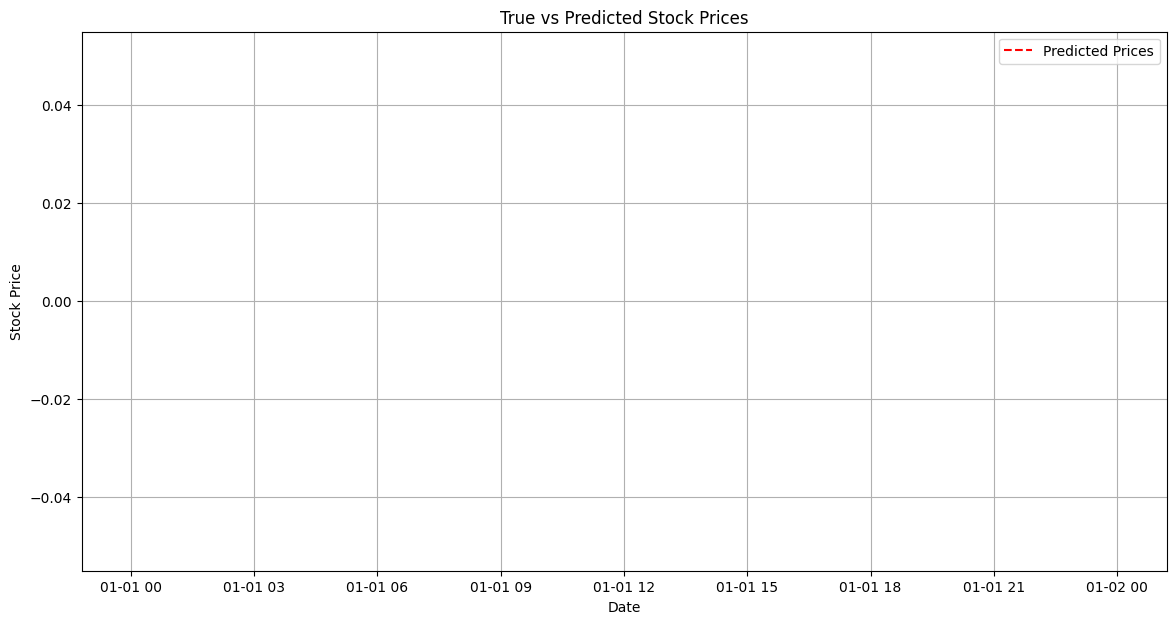

In [ ]:
# Prepare data for the ANN
X = metrics_df.values
predictions = model.predict(X)

# Plot the results
import matplotlib.pyplot as plt

# Ensure predictions and true_prices are aligned
plt.figure(figsize=(14, 7))
# plt.plot(data['AAPL'].index[-len(true_prices):], true_prices, label='True Prices', color='blue')
plt.plot(data['AAPL'].index[-len(predictions):], predictions, label='Predicted Prices', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('True vs Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

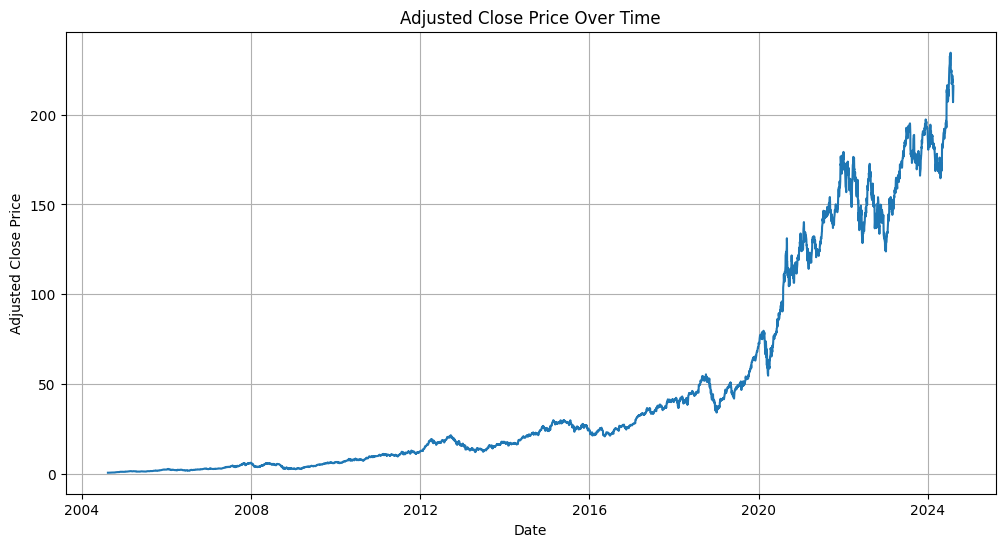

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'company_data' is your DataFrame containing the stock data
plt.figure(figsize=(12, 6))
plt.plot(company_data.index, company_data['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Over Time')
plt.grid(True)
plt.show()

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the tickers and dates
sp500_tickers = ['AAPL']
sector_index_ticker = 'XLC'
start_date = '2012-08-12'
end_date = '2024-08-12'

# Fetch historical data
def fetch_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return data

data = fetch_data(sp500_tickers, start_date, end_date)
sector_index_data = yf.download(sector_index_ticker, start=start_date, end=end_date)

# Calculate metrics
def fetch_company_info(ticker):
    company = yf.Ticker(ticker)
    return company.info

def calculate_metrics(info):
    metrics = {
        'P/E Ratio': info.get('forwardEps') / info.get('previousClose') if info.get('forwardEps') and info.get('previousClose') else None,
        'P/B Ratio': info.get('priceToBook'),
        'Dividend Yield': info.get('dividendYield'),
        'Dividend Payout Ratio': info.get('payoutRatio'),
        'ROE': info.get('returnOnEquity'),
        'ROA': info.get('returnOnAssets'),
        'Beta': info.get('beta'),
        'Market Capitalization': info.get('marketCap'),
        'Revenue Growth': info.get('revenueGrowth'),
        'Debt-to-Equity Ratio': info.get('debtToEquity'),
        'Free Cash Flow': info.get('freeCashflow'),
        'Current Ratio': info.get('currentRatio'),
        'Quick Ratio': info.get('quickRatio'),
        'PEG Ratio': info.get('pegRatio'),
        'Standard Deviation': None,
        'Value at Risk (VaR)': None,
        'Sharpe Ratio': None,
        'Sortino Ratio': None,
        'Maximum Drawdown': None,
        'Downside Deviation': None,
        'Tracking Error': None,
        'R-squared': None,
        'Treynor Ratio': None,
        'Information Ratio': None,
        'Conditional Value at Risk (CVaR)': None,
        'Beta-adjusted Sharpe Ratio': None,
        'Drawdown Duration': None,
        'Ulcer Index': None,
        'Jensen’s Alpha': None
    }
    return metrics

company_info = fetch_company_info('AAPL')
metrics = calculate_metrics(company_info)

# Define functions for calculations
def calculate_standard_deviation(price_data):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.std()

def calculate_var(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.quantile(1 - confidence_level)

def calculate_sharpe_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std()

def calculate_sortino_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std()

def calculate_max_drawdown(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return drawdowns.min()

def calculate_downside_deviation(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    downside_returns = returns[returns < risk_free_rate / 252]
    return downside_returns.std()

def calculate_tracking_error(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.std()

def calculate_r_squared(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    return model.score(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)

def calculate_treynor_ratio(price_data, risk_free_rate=0.01, beta=None):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / beta if beta else None

def calculate_information_ratio(price_data, index_data):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.mean() / excess_returns.std()

def calculate_cvar(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

def calculate_beta(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

def calculate_beta_adjusted_sharpe_ratio(price_data, index_data, risk_free_rate=0.01):
    beta = calculate_beta(price_data, index_data)
    sharpe_ratio = calculate_sharpe_ratio(price_data, risk_free_rate)
    return sharpe_ratio / beta if beta else None

def calculate_drawdown_duration(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    drawdown_duration = (drawdowns < 0).astype(int).groupby((drawdowns >= 0).astype(int).cumsum()).cumsum().max()
    return drawdown_duration

def calculate_ulcer_index(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return (drawdowns ** 2).mean() ** 0.5

def calculate_jensens_alpha(price_data, index_data, risk_free_rate=0.01):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    if len(company_returns) == 0 or len(index_returns) == 0:
        raise ValueError("No overlapping data points found.")
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    beta = calculate_beta(price_data, index_data)
    expected_return = risk_free_rate / 252 + beta * (index_returns_aligned.mean() - risk_free_rate / 252)
    alpha = company_returns_aligned.mean() - expected_return
    return alpha

metrics.update({
    'Standard Deviation': calculate_standard_deviation(data['AAPL']),
    'Value at Risk (VaR)': calculate_var(data['AAPL']),
    'Sharpe Ratio': calculate_sharpe_ratio(data['AAPL']),
    'Sortino Ratio': calculate_sortino_ratio(data['AAPL']),
    'Maximum Drawdown': calculate_max_drawdown(data['AAPL']),
    'Downside Deviation': calculate_downside_deviation(data['AAPL']),
    'Tracking Error': calculate_tracking_error(data['AAPL'], sector_index_data),
    'R-squared': calculate_r_squared(data['AAPL'], sector_index_data),
    'Treynor Ratio': calculate_treynor_ratio(data['AAPL'], beta=company_info.get('beta')),
    'Information Ratio': calculate_information_ratio(data['AAPL'], sector_index_data),
    'Conditional Value at Risk (CVaR)': calculate_cvar(data['AAPL']),
    'Beta-adjusted Sharpe Ratio': calculate_beta_adjusted_sharpe_ratio(data['AAPL'], sector_index_data),
    'Drawdown Duration': calculate_drawdown_duration(data['AAPL']),
    'Ulcer Index': calculate_ulcer_index(data['AAPL']),
    'Jensen’s Alpha': calculate_jensens_alpha(data['AAPL'], sector_index_data)
})

# Prepare data for the ANN
def prepare_data(data, metrics):
    # Use metrics as input features
    X = np.array(list(metrics.values())).reshape(1, -1)
    # Extract adjusted close price as output
    latest_adjusted_close_price = data['AAPL'].iloc[-1]['Adj Close']
    y = np.array([latest_adjusted_close_price])
    return X, y

# Prepare data
X, y = prepare_data(data, metrics)

# Split the data into training and testing sets
def split_data(data, train_years=10, test_years=2):
    total_years = train_years + test_years
    split_date = pd.Timestamp(data['AAPL'].index[-1] - pd.DateOffset(years=test_years))
    train_data = data['AAPL'].loc[data['AAPL'].index <= split_date]
    test_data = data['AAPL'].loc[data['AAPL'].index > split_date]
    return train_data, test_data

train_data, test_data = split_data(data)

# Prepare the ANN model
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create ANN model
model = create_ann_model(len(metrics))

# Train the model
X_train = np.array([list(metrics.values())] * len(train_data)).reshape(len(train_data), -1)
y_train = train_data['Adj Close'].values
model.fit(X_train, y_train, epochs=20)

# Test the model
X_test = np.array([list(metrics.values())] * len(test_data)).reshape(len(test_data), -1)
y_test = test_data['Adj Close'].values
predictions = model.predict(X_test)

# Evaluate the model
mse = np.mean((predictions.flatten() - y_test) ** 2)
print(f"Mean Squared Error on Test Data: {mse}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 16/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
E

In [ ]:
# Define functions (e.g., calculate_standard_deviation, calculate_var, etc.) here

# Fetch and prepare data
data = fetch_data(sp500_tickers, '2012-08-12', '2022-08-12')  # Adjust start date for 10 years
sector_index_data = yf.download(sector_index_ticker, start='2012-08-12', end='2022-08-12')

# Define model and scaler
model = create_ann_model(len(metrics))
scaler = StandardScaler()

# Split data
train_data, test_data = split_data(data)

# Train model
X_train = np.array([list(metrics.values())] * len(train_data)).reshape(len(train_data), -1)
y_train = train_data['Adj Close'].values
X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train_scaled, y_train, epochs=20)

# Calculate metrics for the last 2 years
last_2_years_metrics = calculate_last_2_years_metrics(data['AAPL'], sector_index_data)

# Prepare the data for prediction
X_last_2_years = np.array(list(last_2_years_metrics.values())).reshape(1, -1)
X_last_2_years_scaled = scaler.transform(X_last_2_years)

# Predict and plot
predicted_prices = model.predict(X_last_2_years_scaled)
start_date = data['AAPL'].index[-2*365]  # Approximate start date of the last 2 years
end_date = data['AAPL'].index[-1]
actual_prices = data['AAPL'].loc[start_date:end_date]['Adj Close'].values

dates = data['AAPL'].loc[start_date:end_date].index

plt.figure(figsize=(14, 7))
plt.plot(dates, actual_prices, label='Actual Prices', color='blue')
plt.plot(dates, predicted_prices.flatten(), label='Predicted Prices', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 5059.3760
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4639.0518
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2951.7678
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2168.3159
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2088.4885
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2118.1724
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2272.9656
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2041.6309
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2054.3674
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2122.0068
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2099.9104
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2127.3406
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2255.7256
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2061.4199
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1

NameError: name 'calculate_last_2_years_metrics' is not defined

In [ ]:
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-13,22.263929,22.500000,22.258928,22.500000,19.082273,278832400
2012-08-14,22.566786,22.807501,22.507500,22.560356,19.133457,340169200
2012-08-15,22.546429,22.642857,22.419643,22.529642,19.107414,257342400
2012-08-16,22.543215,22.741428,22.517857,22.726429,19.274311,254534000
2012-08-17,22.857143,23.149643,22.814644,23.146786,19.630816,442761200
...,...,...,...,...,...,...
2022-08-03,160.839996,166.589996,160.750000,166.130005,164.081573,82507500
2022-08-04,166.009995,167.190002,164.429993,165.809998,163.765503,55474100
2022-08-05,163.210007,165.850006,163.000000,165.350006,163.538025,56697000


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load historical data from CSV
company_data = pd.read_csv('AAPL_data.csv', index_col='Date', parse_dates=True)
sector_index_data = pd.read_csv('XLC_data.csv', index_col='Date', parse_dates=True)

# Define function to calculate metrics
def calculate_metrics(info):
    metrics = {
        'P/E Ratio': info.get('forwardEps') / info.get('previousClose') if info.get('forwardEps') and info.get('previousClose') else None,
        'P/B Ratio': info.get('priceToBook'),
        'Dividend Yield': info.get('dividendYield'),
        'Dividend Payout Ratio': info.get('payoutRatio'),
        'ROE': info.get('returnOnEquity'),
        'ROA': info.get('returnOnAssets'),
        'Beta': info.get('beta'),
        'Market Capitalization': info.get('marketCap'),
        'Revenue Growth': info.get('revenueGrowth'),
        'Debt-to-Equity Ratio': info.get('debtToEquity'),
        'Free Cash Flow': info.get('freeCashflow'),
        'Current Ratio': info.get('currentRatio'),
        'Quick Ratio': info.get('quickRatio'),
        'PEG Ratio': info.get('pegRatio'),
        'Standard Deviation': None,
        'Value at Risk (VaR)': None,
        'Sharpe Ratio': None,
        'Sortino Ratio': None,
        'Maximum Drawdown': None,
        'Downside Deviation': None,
        'Tracking Error': None,
        'R-squared': None,
        'Treynor Ratio': None,
        'Information Ratio': None,
        'Conditional Value at Risk (CVaR)': None,
        'Beta-adjusted Sharpe Ratio': None,
        'Drawdown Duration': None,
        'Ulcer Index': None,
        'Jensen’s Alpha': None
    }
    return metrics

# Calculate financial metrics for the company
def calculate_standard_deviation(price_data):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.std()

def calculate_var(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.quantile(1 - confidence_level)

def calculate_sharpe_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std()

def calculate_sortino_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std()

def calculate_max_drawdown(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return drawdowns.min()

def calculate_downside_deviation(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    downside_returns = returns[returns < risk_free_rate / 252]
    return downside_returns.std()

def calculate_tracking_error(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.std()

def calculate_r_squared(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    return model.score(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)

def calculate_treynor_ratio(price_data, risk_free_rate=0.01, beta=None):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / beta if beta else None

def calculate_information_ratio(price_data, index_data):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.mean() / excess_returns.std()

def calculate_cvar(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

def calculate_beta(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

def calculate_beta_adjusted_sharpe_ratio(price_data, index_data, risk_free_rate=0.01):
    beta = calculate_beta(price_data, index_data)
    sharpe_ratio = calculate_sharpe_ratio(price_data, risk_free_rate)
    return sharpe_ratio / beta if beta else None

def calculate_drawdown_duration(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    drawdown_duration = (drawdowns < 0).astype(int).groupby((drawdowns >= 0).astype(int).cumsum()).cumsum().max()
    return drawdown_duration

def calculate_ulcer_index(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return (drawdowns ** 2).mean() ** 0.5

def calculate_jensens_alpha(price_data, index_data, risk_free_rate=0.01):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    beta = calculate_beta(price_data, index_data)
    expected_return = risk_free_rate / 252 + beta * (index_returns_aligned.mean() - risk_free_rate / 252)
    alpha = company_returns_aligned.mean() - expected_return
    return alpha

# Calculate financial metrics
company_info = fetch_company_info('AAPL')
metrics = calculate_metrics(company_info)

# Update metrics with calculations that require the sector index data
metrics.update({
    'Standard Deviation': calculate_standard_deviation(company_data),
    'Value at Risk (VaR)': calculate_var(company_data),
    'Sharpe Ratio': calculate_sharpe_ratio(company_data),
    'Sortino Ratio': calculate_sortino_ratio(company_data),
    'Maximum Drawdown': calculate_max_drawdown(company_data),
    'Downside Deviation': calculate_downside_deviation(company_data),
    'Tracking Error': calculate_tracking_error(company_data, sector_index_data),
    'R-squared': calculate_r_squared(company_data, sector_index_data),
    'Treynor Ratio': calculate_treynor_ratio(company_data, beta=metrics.get('Beta')),
    'Information Ratio': calculate_information_ratio(company_data, sector_index_data),
    'Conditional Value at Risk (CVaR)': calculate_cvar(company_data),
    'Beta-adjusted Sharpe Ratio': calculate_beta_adjusted_sharpe_ratio(company_data, sector_index_data),
    'Drawdown Duration': calculate_drawdown_duration(company_data),
    'Ulcer Index': calculate_ulcer_index(company_data),
    'Jensen’s Alpha': calculate_jensens_alpha(company_data, sector_index_data)
})

# Prepare data for ANN
X = company_data[['P/E Ratio', 'P/B Ratio', 'Dividend Yield', 'Dividend Payout Ratio', 'ROE', 'ROA', 'Beta', 'Market Capitalization',
                  'Revenue Growth', 'Debt-to-Equity Ratio', 'Free Cash Flow', 'Current Ratio', 'Quick Ratio', 'PEG Ratio',
                  'Standard Deviation', 'Value at Risk (VaR)', 'Sharpe Ratio', 'Sortino Ratio', 'Maximum Drawdown',
                  'Downside Deviation', 'Tracking Error', 'R-squared', 'Treynor Ratio', 'Information Ratio', 
                  'Conditional Value at Risk (CVaR)', 'Beta-adjusted Sharpe Ratio', 'Drawdown Duration', 'Ulcer Index', 
                  'Jensen’s Alpha']]
y = company_data['Adj Close']

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on test data: {loss}")

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


KeyError: "None of [Index(['P/E Ratio', 'P/B Ratio', 'Dividend Yield', 'Dividend Payout Ratio',\n       'ROE', 'ROA', 'Beta', 'Market Capitalization', 'Revenue Growth',\n       'Debt-to-Equity Ratio', 'Free Cash Flow', 'Current Ratio',\n       'Quick Ratio', 'PEG Ratio', 'Standard Deviation', 'Value at Risk (VaR)',\n       'Sharpe Ratio', 'Sortino Ratio', 'Maximum Drawdown',\n       'Downside Deviation', 'Tracking Error', 'R-squared', 'Treynor Ratio',\n       'Information Ratio', 'Conditional Value at Risk (CVaR)',\n       'Beta-adjusted Sharpe Ratio', 'Drawdown Duration', 'Ulcer Index',\n       'Jensen’s Alpha'],\n      dtype='object')] are in the [columns]"

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [15]:
# Define the SP500 ticker and sector index ticker
sp500_ticker = 'AAPL'  # Example ticker
sector_index_ticker = 'XLC'  # Example sector index ticker for Technology

# Calculate date range
end_date = datetime.now()
start_date = end_date - timedelta(days=365*12)  # 12 years ago

# Fetch historical data
def fetch_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

company_data = fetch_data(sp500_ticker, start_date, end_date)
sector_index_data = fetch_data(sector_index_ticker, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [17]:
# Function to calculate metrics
def calculate_metrics(company_data, sector_index_data, company_info):
    metrics = {
        'P/E Ratio': company_info.get('forwardEps') / company_info.get('previousClose') if company_info.get('forwardEps') and company_info.get('previousClose') else None,
        'P/B Ratio': company_info.get('priceToBook'),
        'Dividend Yield': company_info.get('dividendYield'),
        'Dividend Payout Ratio': company_info.get('payoutRatio'),
        'ROE': company_info.get('returnOnEquity'),
        'ROA': company_info.get('returnOnAssets'),
        'Beta': company_info.get('beta'),
        'Market Capitalization': company_info.get('marketCap'),
        'Revenue Growth': company_info.get('revenueGrowth'),
        'Debt-to-Equity Ratio': company_info.get('debtToEquity'),
        'Free Cash Flow': company_info.get('freeCashflow'),
        'Current Ratio': company_info.get('currentRatio'),
        'Quick Ratio': company_info.get('quickRatio'),
        'PEG Ratio': company_info.get('pegRatio'),
        'Standard Deviation': calculate_standard_deviation(company_data),
        'Value at Risk (VaR)': calculate_var(company_data),
        'Sharpe Ratio': calculate_sharpe_ratio(company_data),
        'Sortino Ratio': calculate_sortino_ratio(company_data),
        'Maximum Drawdown': calculate_max_drawdown(company_data),
        'Downside Deviation': calculate_downside_deviation(company_data),
        'Tracking Error': calculate_tracking_error(company_data, sector_index_data),
        'R-squared': calculate_r_squared(company_data, sector_index_data),
        'Treynor Ratio': calculate_treynor_ratio(company_data, beta=company_info.get('beta')),
        'Information Ratio': calculate_information_ratio(company_data, sector_index_data),
        'Conditional Value at Risk (CVaR)': calculate_cvar(company_data),
        'Beta-adjusted Sharpe Ratio': calculate_beta_adjusted_sharpe_ratio(company_data, sector_index_data),
        'Drawdown Duration': calculate_drawdown_duration(company_data),
        'Ulcer Index': calculate_ulcer_index(company_data),
        'Jensens Alpha': calculate_jensens_alpha(company_data, sector_index_data)
    }
    return metrics


In [18]:

# Calculate financial metrics for the company
def calculate_standard_deviation(price_data):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.std()

def calculate_var(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    return returns.quantile(1 - confidence_level)

def calculate_sharpe_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std()

def calculate_sortino_ratio(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252
    downside_returns = excess_returns[excess_returns < 0]
    return excess_returns.mean() / downside_returns.std()

def calculate_max_drawdown(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return drawdowns.min()

def calculate_downside_deviation(price_data, risk_free_rate=0.01):
    returns = price_data['Adj Close'].pct_change().dropna()
    downside_returns = returns[returns < risk_free_rate / 252]
    return downside_returns.std()

def calculate_tracking_error(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.std()

def calculate_r_squared(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    model = LinearRegression().fit(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)
    return model.score(index_returns_aligned.values.reshape(-1, 1), company_returns_aligned.values)

def calculate_treynor_ratio(price_data, risk_free_rate=0.01, beta=None):
    returns = price_data['Adj Close'].pct_change().dropna()
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / beta if beta else None

def calculate_information_ratio(price_data, index_data):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    excess_returns = company_returns_aligned - index_returns_aligned
    return excess_returns.mean() / excess_returns.std()

def calculate_cvar(price_data, confidence_level=0.95):
    returns = price_data['Adj Close'].pct_change().dropna()
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

def calculate_beta(company_data, index_data):
    common_dates = company_data.index.intersection(index_data.index)
    company_returns = company_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    covariance_matrix = np.cov(company_returns_aligned, index_returns_aligned)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

def calculate_beta_adjusted_sharpe_ratio(price_data, index_data, risk_free_rate=0.01):
    beta = calculate_beta(price_data, index_data)
    sharpe_ratio = calculate_sharpe_ratio(price_data, risk_free_rate)
    return sharpe_ratio / beta if beta else None

def calculate_drawdown_duration(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    drawdown_duration = (drawdowns < 0).astype(int).groupby((drawdowns >= 0).astype(int).cumsum()).cumsum().max()
    return drawdown_duration

def calculate_ulcer_index(price_data):
    rolling_max = price_data['Adj Close'].cummax()
    drawdowns = (price_data['Adj Close'] - rolling_max) / rolling_max
    return (drawdowns ** 2).mean() ** 0.5

def calculate_jensens_alpha(price_data, index_data, risk_free_rate=0.01):
    common_dates = price_data.index.intersection(index_data.index)
    company_returns = price_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    index_returns = index_data.loc[common_dates, 'Adj Close'].pct_change().dropna()
    aligned_data = pd.concat([company_returns, index_returns], axis=1).dropna()
    company_returns_aligned = aligned_data.iloc[:, 0]
    index_returns_aligned = aligned_data.iloc[:, 1]
    beta = calculate_beta(price_data, index_data)
    expected_return = risk_free_rate / 252 + beta * (index_returns_aligned.mean() - risk_free_rate / 252)
    alpha = company_returns_aligned.mean() - expected_return
    return alpha


In [19]:
# Calculate metrics for each date
def calculate_metrics_for_dates(company_data, sector_index_data):
    dates = company_data.index
    metrics_list = []
    
    company = yf.Ticker(sp500_ticker)
    company_info = company.info

    for date in dates:
        subset_company_data = company_data.loc[:date]
        subset_sector_index_data = sector_index_data.loc[:date]
        
        metrics = calculate_metrics(subset_company_data, subset_sector_index_data, company_info)
        metrics['Adj Close'] = subset_company_data['Adj Close'].iloc[-1]
        metrics_list.append(metrics)

    return pd.DataFrame(metrics_list, index=dates)



In [20]:

# Calculate metrics for all dates
all_metrics_df = calculate_metrics_for_dates(company_data, sector_index_data)

# Save the data to CSV
all_metrics_df.to_csv(f'{sp500_ticker}_metrics.csv')



ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the data
def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    return data[(data.index >= '2012-01-01') & (data.index <= '2020-12-31')]

# Prepare data for LSTM
def prepare_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predicting the 'Close' price
    
    return np.array(X), np.array(y), scaler

# Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train model
def train_model(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.2):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=False
    )
    return history

# Make predictions
def make_predictions(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

# Evaluate model
def evaluate_model(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae

# Plot results
def plot_results(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('LSTM Model: Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Main function
def main():
    # Load data
    file_path = 'AAPL_data_with_metrics.csv'  # Replace with your CSV file name
    data = load_data(file_path)
    
    # Select features for training
    features = ['Close', 'P/E Ratio', 'P/B Ratio', 'Dividend Yield', 'Dividend Payout Ratio', 
                'ROE', 'ROA', 'Beta', 'Market Capitalization', 'Revenue Growth', 
                'Debt-to-Equity Ratio', 'Free Cash Flow', 'Current Ratio', 'Quick Ratio', 
                'PEG Ratio', 'Standard Deviation', 'Value at Risk (VaR)', 'Sharpe Ratio', 
                'Sortino Ratio', 'Maximum Drawdown', 'Downside Deviation', 'Tracking Error', 
                'R-squared', 'Treynor Ratio', 'Information Ratio', 'Conditional Value at Risk (CVaR)', 
                'Beta-adjusted Sharpe Ratio', 'Drawdown Duration', 'Ulcer Index', 'Jensens Alpha']
    
    data = data[features]
    
    # Prepare data for LSTM
    X, y, scaler = prepare_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Build and train model
    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    history = train_model(model, X_train, y_train)
    
    # Make predictions
    y_pred = make_predictions(model, X_test, scaler)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Evaluate model
    mse, rmse, mae = evaluate_model(y_test_inv, y_pred)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Plot results
    plot_results(y_test_inv, y_pred)

if __name__ == "__main__":
    main()